In [19]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import imgLoader as ld
from drawMap import drawMapGrid
import json

%load_ext autoreload
%autoreload 2

OUTPUT_IMG_SIZE = [3600, 1800]

PLANET_RADIUS = 260
OM_RAD = 380.53
OM = [None, 
      [0, 0, +OM_RAD], 
      [0, 0, -OM_RAD], 
      [0, +OM_RAD, 0],
      [0, -OM_RAD, 0], 
      [+OM_RAD, 0, 0], 
      [-OM_RAD, 0, 0]]

PATH = "./images/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Input Image

Preprocess the image

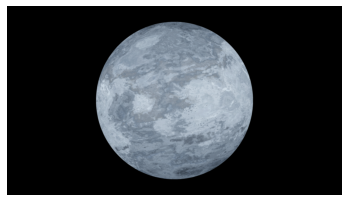

{
    "dim": [
        3840,
        2160
    ],
    "distance": {
        "om1": 593.7,
        "om2": null,
        "om3": 336.4,
        "om4": null,
        "om5": null,
        "om6": 310.2,
        "plt": 448.2
    },
    "fovU": 112,
    "planetName": "Cellin",
    "useCenter": [
        1920,
        1080
    ],
    "useRadius": 900
}


In [20]:
# Read the image & metadata
try: 
    img5, img5Meta = ld.readImg(PATH, "Cellin_5_cropped", "Cellin_5")
except:
    print("Cropped image not found!")
    img5, img5Meta = ld.readImg(PATH, "Cellin_5", "Cellin_5")
    ld.showImg(img5)
    ld.showImgUseArea(img5, img5Meta)
    img5_cropped = ld.keepUsePixels(img5, img5Meta)
    ld.saveImg(img5_cropped, PATH, "Cellin_5")
finally:
    ld.showImg(img5)
    ld.printMeta(img5Meta)
    
img5_cropped = img5


# ORB 

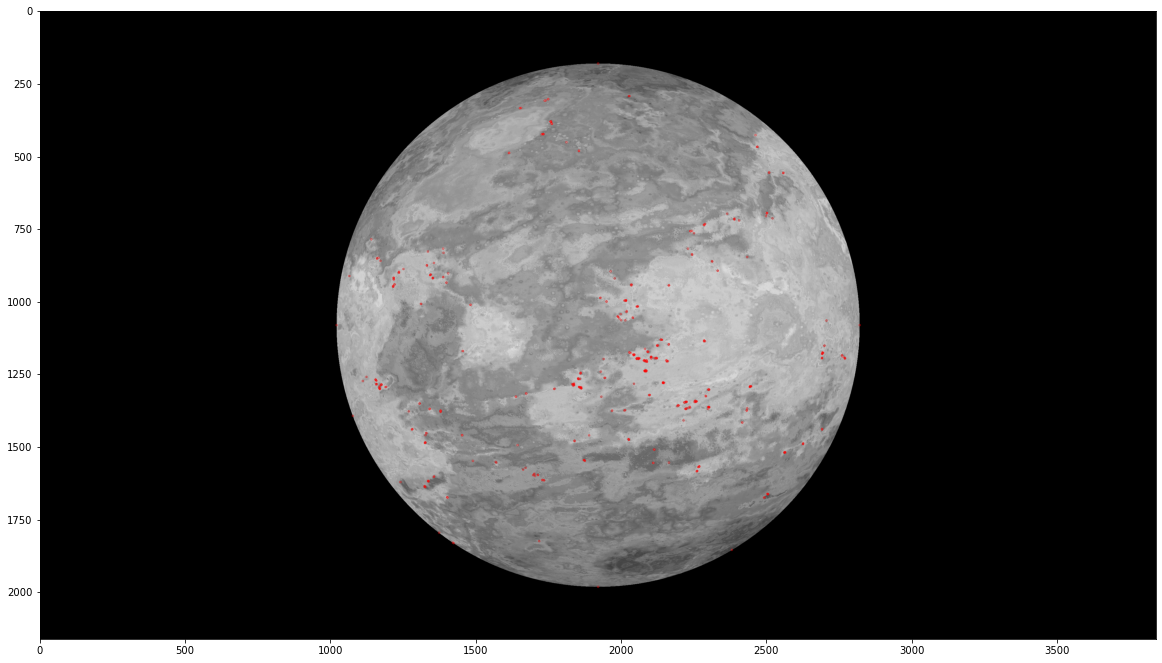

(<matplotlib.image.AxesImage at 0x7fd62961bf70>, None)

In [21]:
 
img = cv.imread('images/Cellin_5_cropped.png', cv.IMREAD_GRAYSCALE)
 
# Initiate ORB detector
orb = cv.ORB_create()
 
# find the keypoints with ORB
kp = orb.detect(img,None)
 
# compute the descriptors with ORB
kp, des = orb.compute(img, kp)
plt.figure(figsize = (20,20))
# draw only keypoints location,not size and orientation
img2 = cv.drawKeypoints(img, kp, None, color=(255,0,0), flags=0)
plt.imshow(img2), plt.show()



In [22]:
 
img1 = cv.imread('images/Cellin_5_cropped.png',cv.IMREAD_GRAYSCALE) # queryImage
img2 = cv.imread('images/Cellin_6_cropped.png',cv.IMREAD_GRAYSCALE) # trainImage




# Create a mask for half of the image
height, width = img1.shape[:2]
mask = np.zeros_like(img1)
mask[:, width // 2:] = 255

# Apply the mask using OpenCV function
masked = cv.bitwise_and(img1, mask)

img1 = masked


# Create a mask for half of the image
height, width = img2.shape[:2]
mask = np.zeros_like(img2)
mask[:, :width // 2] = 255

# Apply the mask using OpenCV function
masked = cv.bitwise_and(img2, mask)

img2 = masked

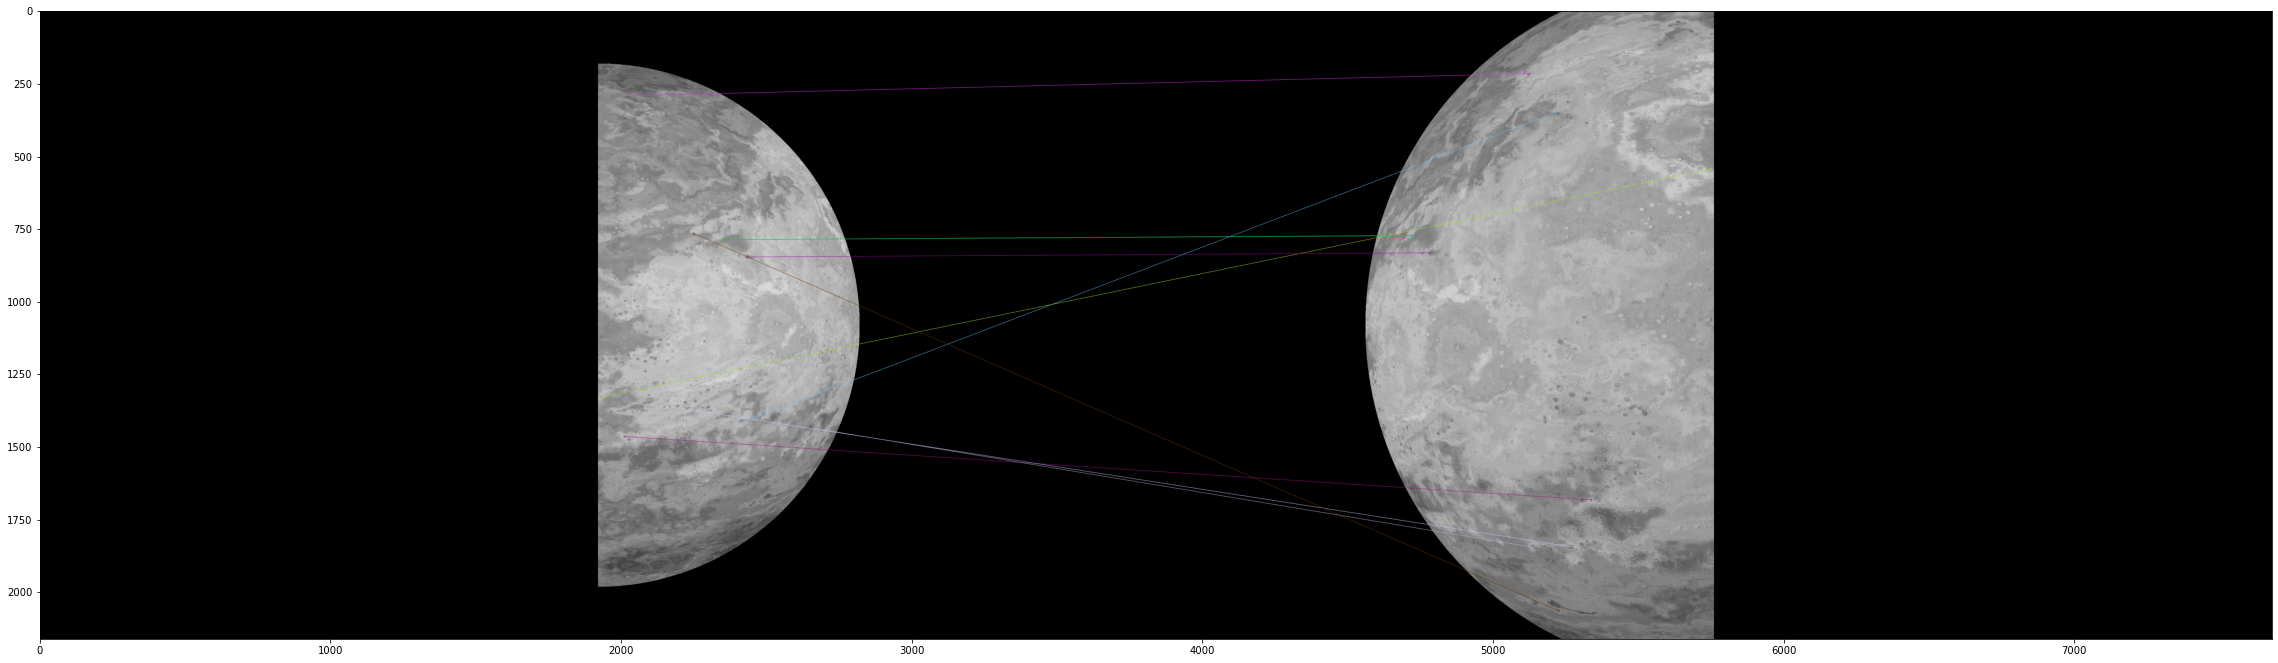

(<matplotlib.image.AxesImage at 0x7fd61abb0430>, None)

In [23]:
# Initiate ORB detector
orb = cv.ORB_create()
 
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)



# create BFMatcher object
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
 
# Match descriptors.
matches = bf.match(des1,des2)
 
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
 
# Draw first 10 matches.
img3 = cv.drawMatches(img1,kp1,img2,kp2,matches[:10],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (40,20))
plt.imshow(img3),plt.show()

# SIFT

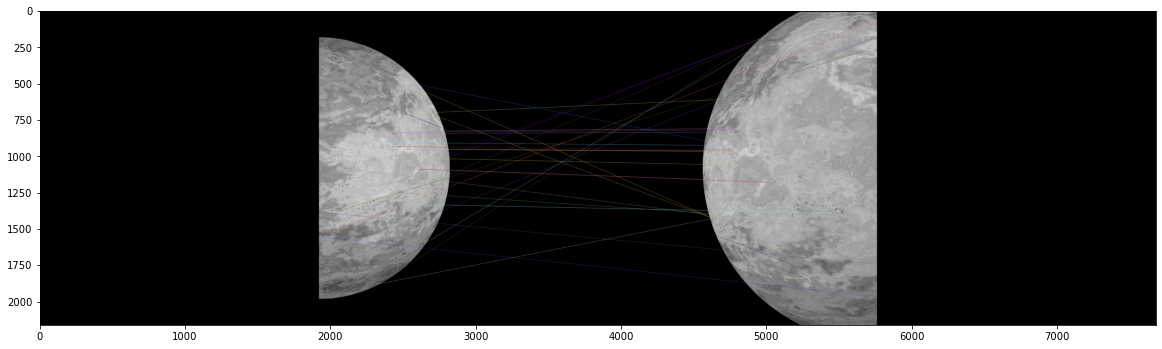

(<matplotlib.image.AxesImage at 0x7fd5c37128b0>, None)

In [24]:

 
# Initiate SIFT detector
sift = cv.SIFT_create()
 
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
 
# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
 
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
 
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (20,20))
plt.imshow(img3),plt.show()


In [27]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
FLANN_INDEX_LSH = 6
index_params= dict(algorithm = FLANN_INDEX_LSH,
 table_number = 6, # 12
 key_size = 12, # 20
 multi_probe_level = 1) #2


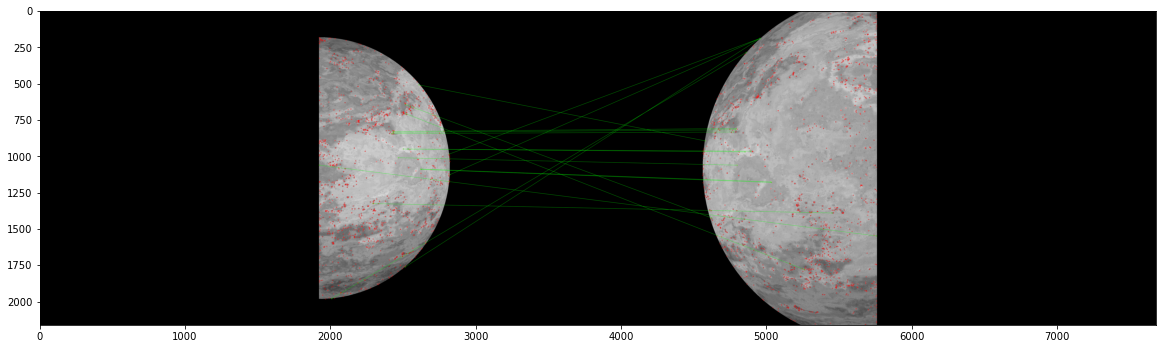

(<matplotlib.image.AxesImage at 0x7fd5b7a2fc10>, None)

In [28]:
# Initiate SIFT detector
sift = cv.SIFT_create()
 
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
 
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50) # or pass empty dictionary
 
flann = cv.FlannBasedMatcher(index_params,search_params)
 
matches = flann.knnMatch(des1,des2,k=2)
 
# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]
 
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
 
draw_params = dict(matchColor = (0,255,0),
    singlePointColor = (255,0,0),
    matchesMask = matchesMask,
    flags = cv.DrawMatchesFlags_DEFAULT)
 
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
plt.figure(figsize = (20,20))
plt.imshow(img3,),plt.show()

# Quadrilateral location
Compute the camera location with four distances to four known points.

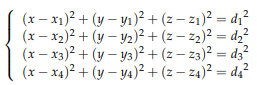

In [3]:
def quadrilateral(x1y1z1, d1, x2y2z2, d2, x3y3z3, d3, x4y4z4, d4):
    x1, y1, z1 = x1y1z1
    x2, y2, z2 = x2y2z2
    x3, y3, z3 = x3y3z3
    x4, y4, z4 = x4y4z4
    A11 = 2 * (x1 - x2)
    A12 = 2 * (y1 - y2)
    A13 = 2 * (z1 - z2)
    A21 = 2 * (x1 - x3)
    A22 = 2 * (y1 - y3)
    A23 = 2 * (z1 - z3)
    A31 = 2 * (x1 - x4)
    A32 = 2 * (y1 - y4)
    A33 = 2 * (z1 - z4)
    temp1 = d1**2 - x1**2 - y1**2 - z1**2
    b1 = d2**2 - x2**2 - y2**2 - z2**2 - temp1
    b2 = d3**2 - x3**2 - y3**2 - z3**2 - temp1
    b3 = d4**2 - x4**2 - y4**2 - z4**2 - temp1
    A = np.array([[A11, A12, A13], 
                     [A21, A22, A23], 
                     [A31, A32, A33]])
    b = np.array([[b1],
                     [b2],
                     [b3]])
    AInv = np.linalg.inv(A)
    result = AInv.dot(b)
    return result[0, 0], result[1, 0], result[2, 0]


Image shot at: 
(-327.78267271962784, 305.52303484613566, -8.926193861193727)


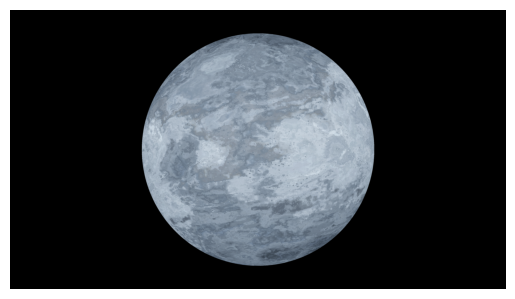

In [4]:
cam5pos = quadrilateral([0, 0, 0], 448.2, OM[1], 593.7, OM[3], 336.4, OM[6], 310.2)
print("Image shot at: ")
print(cam5pos)
plt.imshow(img5_cropped)
plt.axis('off')  # Turn off axis
plt.show()


Put points in model. The test camera location seems correct.

https://www.geogebra.org/calculator/hrqzetby


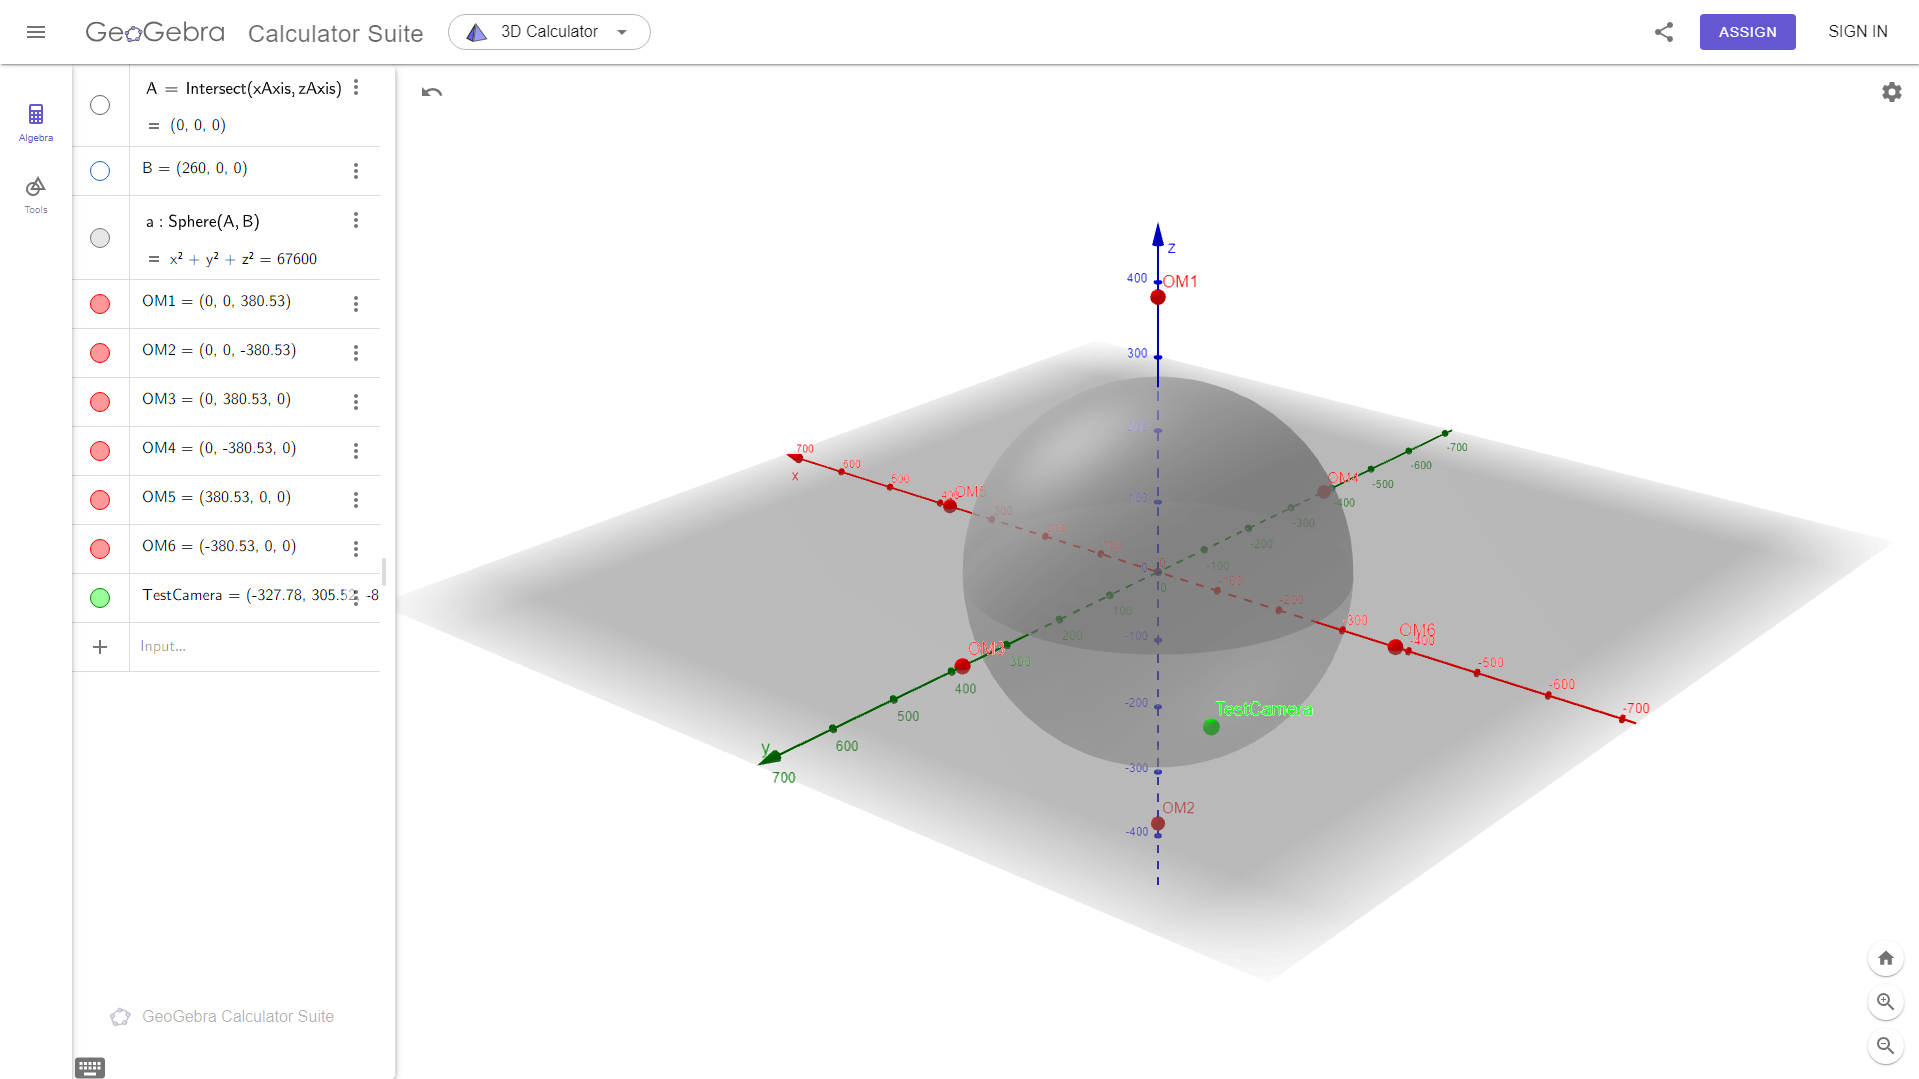

### Project Camera Orbital Position to the ground coordinate system

In [5]:
import math
def projectToGround(orbitalPos):
    x, y, z = orbitalPos
    long = math.atan(-x / y) * 180 / math.pi
    if y < 0:
        long = 180 + long
    elif x > 0 and y > 0:
        long = 360 + long
    xydis = (x**2 + y**2) ** 0.5
    la = math.atan(z / xydis) * 180 / math.pi
    return [long, la]

Projected to ground at: 
[47.013022261389104, -1.1412085247938502]


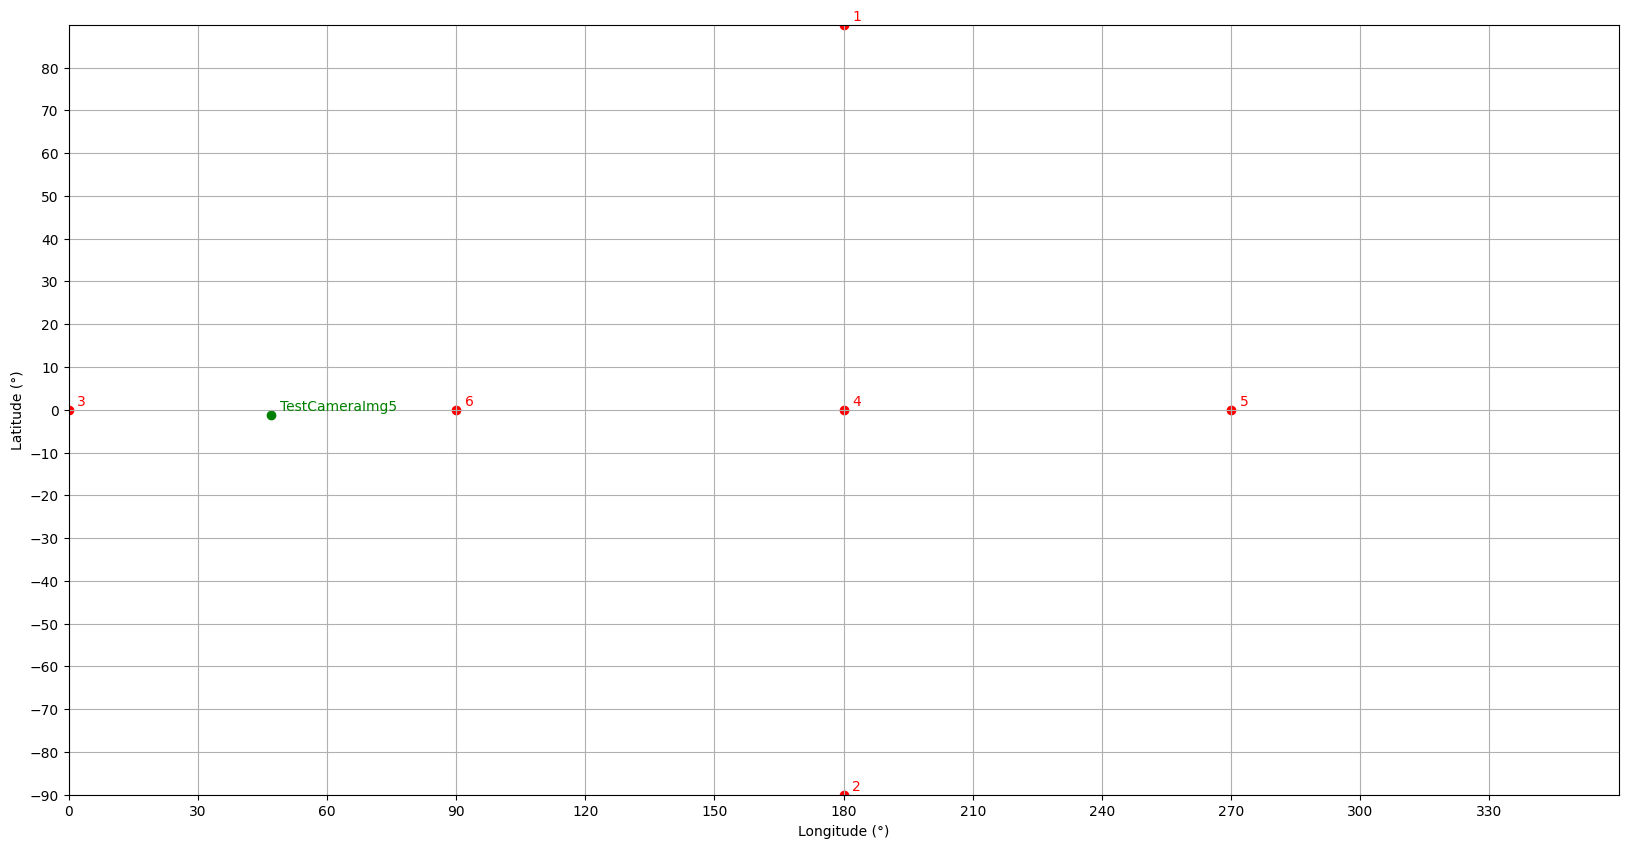

In [6]:
cam5longla = projectToGround(cam5pos)
print("Projected to ground at: ")
print(cam5longla)

drawMapGrid(None, [cam5longla], ["TestCameraImg5"])

# Single Image Projection
Map a single image to the longitude-latitude grid system.

Assume the location and rotation are known.

In [7]:
def longlaToInputImgUV(longla, inputImg, inputFov, inputCenterLongLa, camPos):
    inputUMax = inputImg.shape[1]
    inputVMax = inputImg.shape[0]
    inputCenterU = inputUMax / 2
    inputCenterV = inputVMax / 2
    inputCenterLong = inputCenterLongLa[0]
    inputCenterLati = inputCenterLongLa[1]
    localLong = longla[0] - inputCenterLong
    localLati = longla[1] - inputCenterLati
    # Max localLong & La: the contact point between the sphere and tangent line from camera.
    maxLocalLongLa = math.acos(PLANET_RADIUS / np.linalg.norm(camPos)) / math.pi * 180
    # Stop calculate if localLong and localLati is outside the horizon/contact circle
    if np.linalg.norm([localLong, localLati]) > maxLocalLongLa: return None, None
    # Calculate x, y, z from localLong and localLati relatives to camera's coordspace: 
    # x: image plane x, 
    # y: image plane y, 
    # z: image normal, centered at planet's center, towards the image
    localX = PLANET_RADIUS * math.cos(localLati * math.pi / 180) * math.sin(localLong * math.pi / 180)
    localZ = PLANET_RADIUS * math.cos(localLati * math.pi / 180) * math.cos(localLong * math.pi / 180)
    localY = PLANET_RADIUS * math.sin(localLati * math.pi / 180)
    
    focal = inputUMax / 2 / math.tan(inputFov / 2 * math.pi / 180)
    
    imgU = inputCenterU + focal / (abs(np.linalg.norm(camPos)) - localZ) * localX
    imgV = inputCenterV + focal / (abs(np.linalg.norm(camPos)) - localZ) * localY
    return round(imgU), round(imgV)

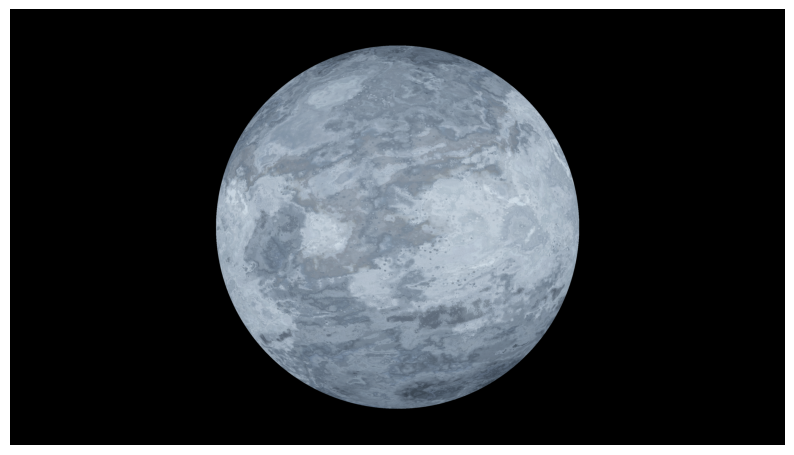

In [8]:
plt.figure(figsize=(10, 20))     
plt.imshow(img5_cropped)
plt.axis('off')  # Turn off axis
plt.show()

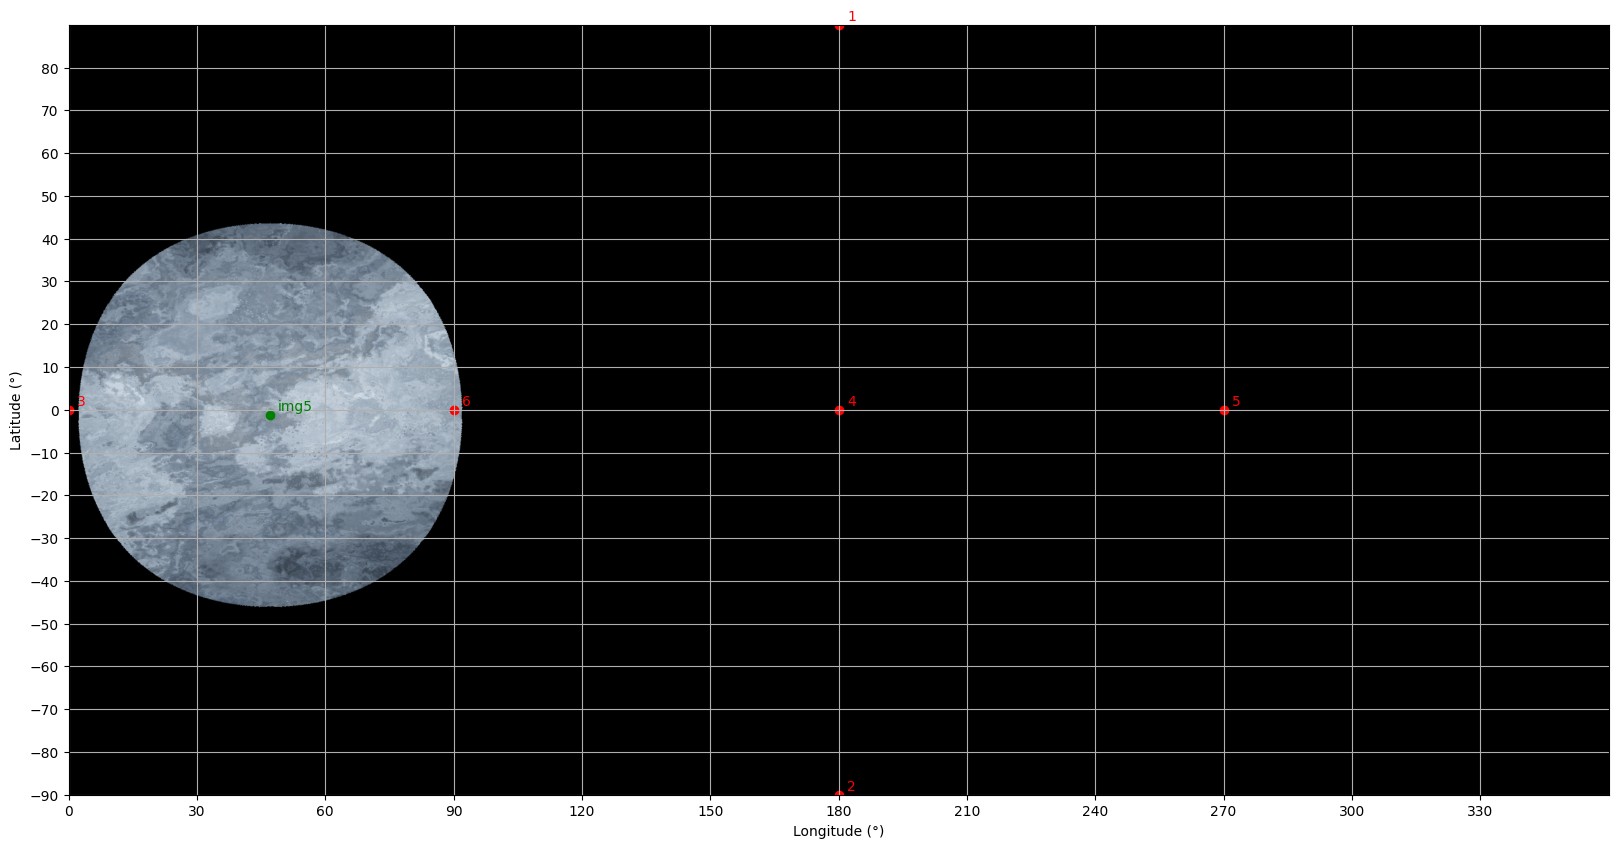

In [9]:
testMap = np.zeros((OUTPUT_IMG_SIZE[1], OUTPUT_IMG_SIZE[0], 3))
for v in range(OUTPUT_IMG_SIZE[1]):
    for u in range(OUTPUT_IMG_SIZE[0]):
        la = -v / OUTPUT_IMG_SIZE[1] * 180 + 90
        lo = u / OUTPUT_IMG_SIZE[0] * 360
        uInput, vInput = longlaToInputImgUV([lo, la], img5_cropped, img5Meta["fovU"], cam5longla, cam5pos)
        if uInput is None or not (0 <= uInput < img5_cropped.shape[1] and 0 <= vInput < img5_cropped.shape[0]): 
            testMap[v, u] = [0, 0, 0]
            continue
        testMap[v, u] = img5_cropped[-vInput, uInput]

drawMapGrid(testMap, [cam5longla], ["img5"])

# Initial Exploration: Direct map with known location and rotation
Assume both img5 and img6's location and rotation are known and accurate.  
Location: using metadata.  
Rotation: image center/ camera center directly pointing to sphere's center. camera's up is aligned with north pole (OM1).


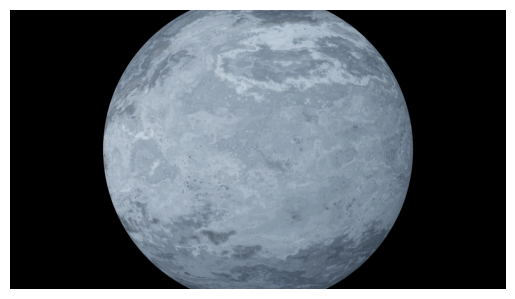

{
    "dim": [
        3840,
        2160
    ],
    "distance": {
        "om1": null,
        "om2": null,
        "om3": null,
        "om4": null,
        "om5": null,
        "om6": 0,
        "plt": null
    },
    "fovU": 112,
    "planetName": "Cellin",
    "useCenter": [
        1920,
        1080
    ],
    "useRadius": 1200
}


In [10]:
img6, img6Meta = ld.readImg(PATH, "Cellin_6_cropped", "Cellin_6")

ld.showImg(img6)
ld.printMeta(img6Meta)

Camera position is known: at OM6

In [11]:
cam6longla = [90, 0]
cam6pos = OM[6]

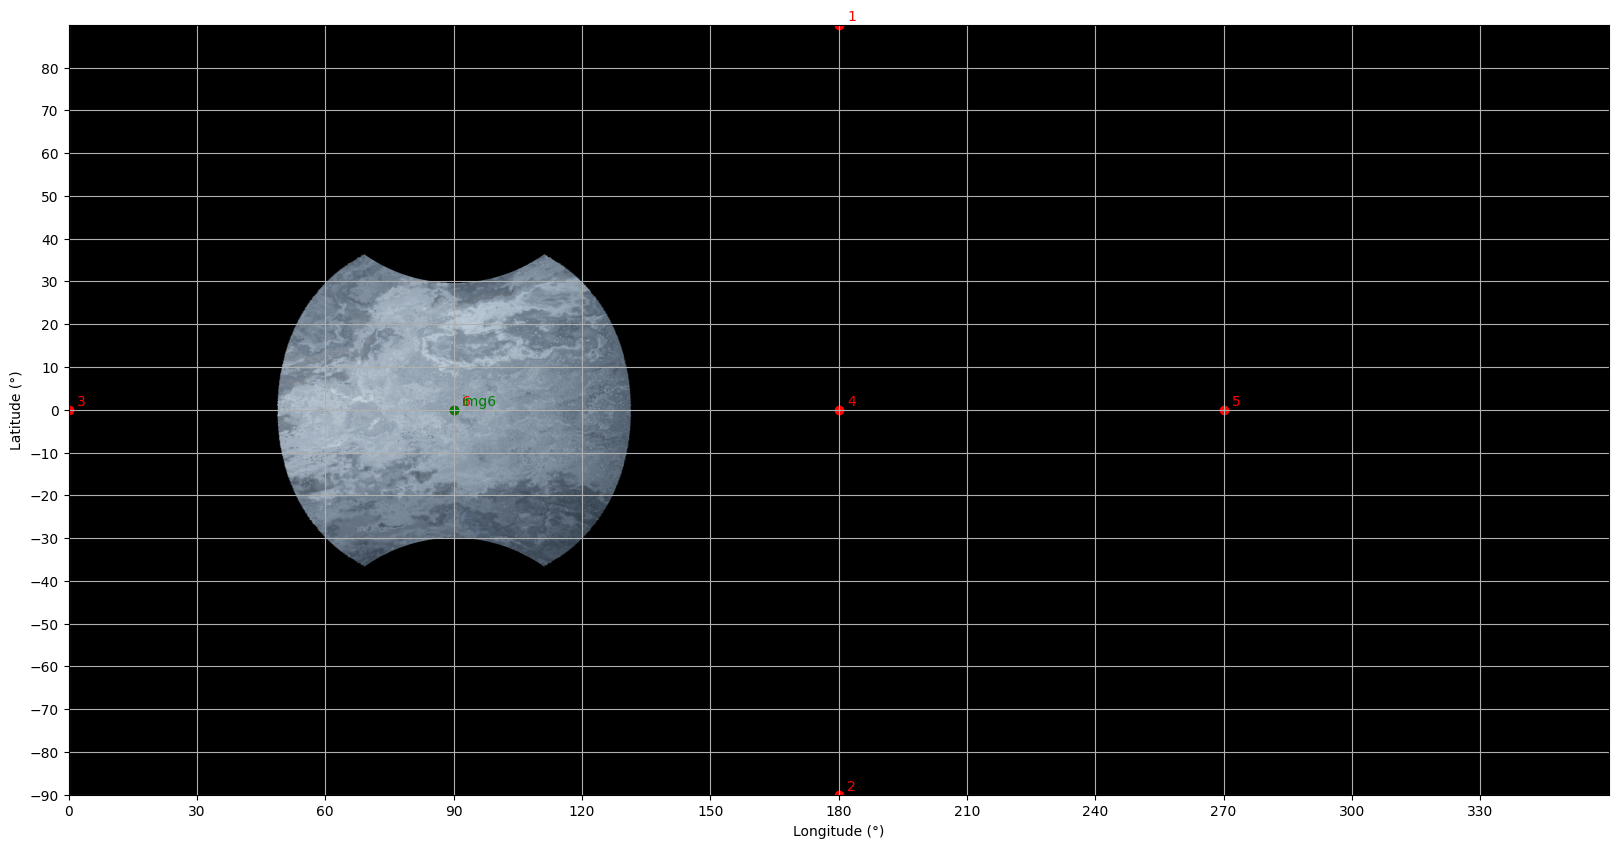

In [12]:
testMap2 = np.zeros((OUTPUT_IMG_SIZE[1], OUTPUT_IMG_SIZE[0], 3))

for v in range(OUTPUT_IMG_SIZE[1]):
    for u in range(OUTPUT_IMG_SIZE[0]):
        la = -v / OUTPUT_IMG_SIZE[1] * 180 + 90
        lo = u / OUTPUT_IMG_SIZE[0] * 360
        uInput, vInput = longlaToInputImgUV([lo, la], img6, img6Meta["fovU"], cam6longla, cam6pos)
        if uInput is None or not (0 <= uInput < img6.shape[1] and 0 <= vInput < img6.shape[0]): 
            testMap2[v, u] = [0, 0, 0]
            continue
        testMap2[v, u] = img6[-vInput, uInput]

drawMapGrid(testMap2, [cam6longla], ["img6"])

### Combine 2 maps (average)

In [13]:
combineMap = np.zeros((OUTPUT_IMG_SIZE[1], OUTPUT_IMG_SIZE[0], 3))

for v in range(OUTPUT_IMG_SIZE[1]):
    for u in range(OUTPUT_IMG_SIZE[0]):
        if (testMap[v,u] != [0, 0, 0]).all() and (testMap2[v,u] != [0, 0, 0]).all():
            combineMap[v,u] = (testMap[v,u] + testMap2[v,u]) / 2
        else:
            combineMap[v,u] = (testMap[v,u] + testMap2[v,u])

IMG 5: shot at (-327.78267271962784, 305.52303484613566, -8.926193861193727)


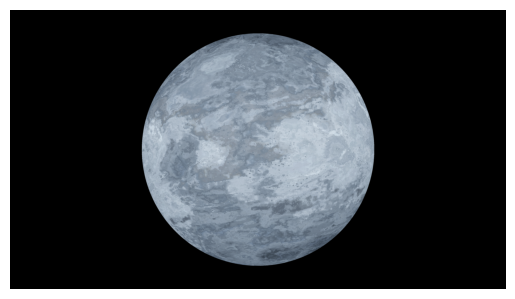

IMG 6: shot at [-380.53, 0, 0]


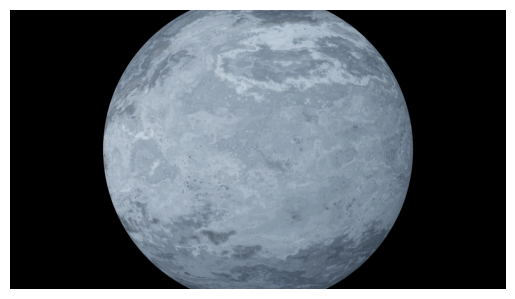

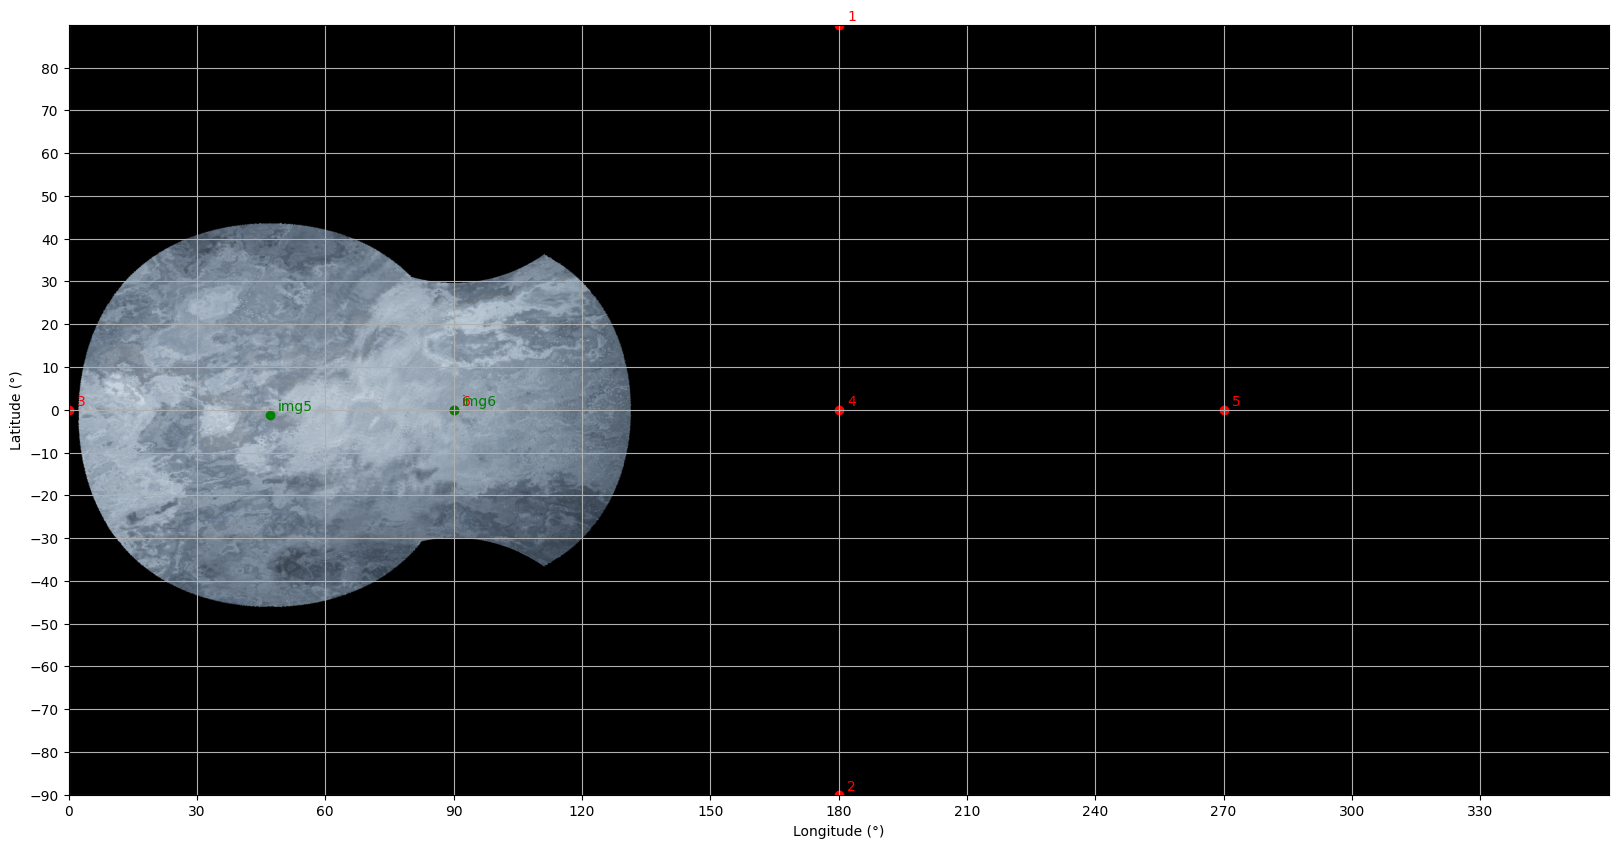

In [14]:
print("IMG 5: shot at {}".format(cam5pos))
ld.showImg(img5)
print("IMG 6: shot at {}".format(cam6pos))
ld.showImg(img6)
drawMapGrid(combineMap, [cam5longla, cam6longla], ["img5", "img6"])

The overlapped map shows the direct mappings are fairly accurate. But still has some mismatch.   
The mismatch may mainly caused by the rotation error, and minorly caused by position error.

## Add more images

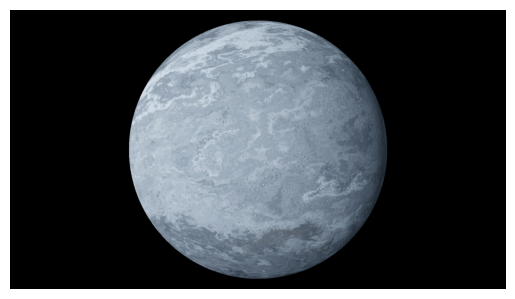

{
    "dim": [
        1920,
        1080
    ],
    "distance": {
        "om1": 568.6,
        "om2": null,
        "om3": null,
        "om4": 312.5,
        "om5": null,
        "om6": 307.8,
        "plt": 423.3
    },
    "fovU": 112,
    "planetName": "Cellin",
    "useCenter": [
        960,
        540
    ],
    "useRadius": 500
}


In [15]:
img4, img4Meta = ld.readImg(PATH, "Cellin_4_cropped", "Cellin_4")

ld.showImg(img4)
ld.printMeta(img4Meta)

In [16]:
cam4pos = quadrilateral(
    [0, 0, 0], img4Meta["distance"]["plt"], 
    OM[1], img4Meta["distance"]["om1"], 
    OM[4], img4Meta["distance"]["om4"], 
    OM[6], img4Meta["distance"]["om6"])
print("Image 4 shot at: ")
print(cam4pos)

cam4longla = projectToGround(cam4pos)
print("Projected to ground at: ")
print(cam4longla)

Image 4 shot at: 
(-301.2182099965837, -297.38748705752505, 0.893504979896414)
Projected to ground at: 
[134.63334585369458, 0.12094397110583033]


In [17]:
testMap3 = np.zeros((OUTPUT_IMG_SIZE[1], OUTPUT_IMG_SIZE[0], 3))
for v in range(OUTPUT_IMG_SIZE[1]):
    for u in range(OUTPUT_IMG_SIZE[0]):
        la = -v / OUTPUT_IMG_SIZE[1] * 180 + 90
        lo = u / OUTPUT_IMG_SIZE[0] * 360
        uInput, vInput = longlaToInputImgUV([lo, la], img4, img4Meta["fovU"], cam4longla, cam4pos)
        if uInput is None or not (0 <= uInput < img4.shape[1] and 0 <= vInput < img4.shape[0]): 
            testMap3[v, u] = [0, 0, 0]
            continue
        testMap3[v, u] = img4[-vInput, uInput]

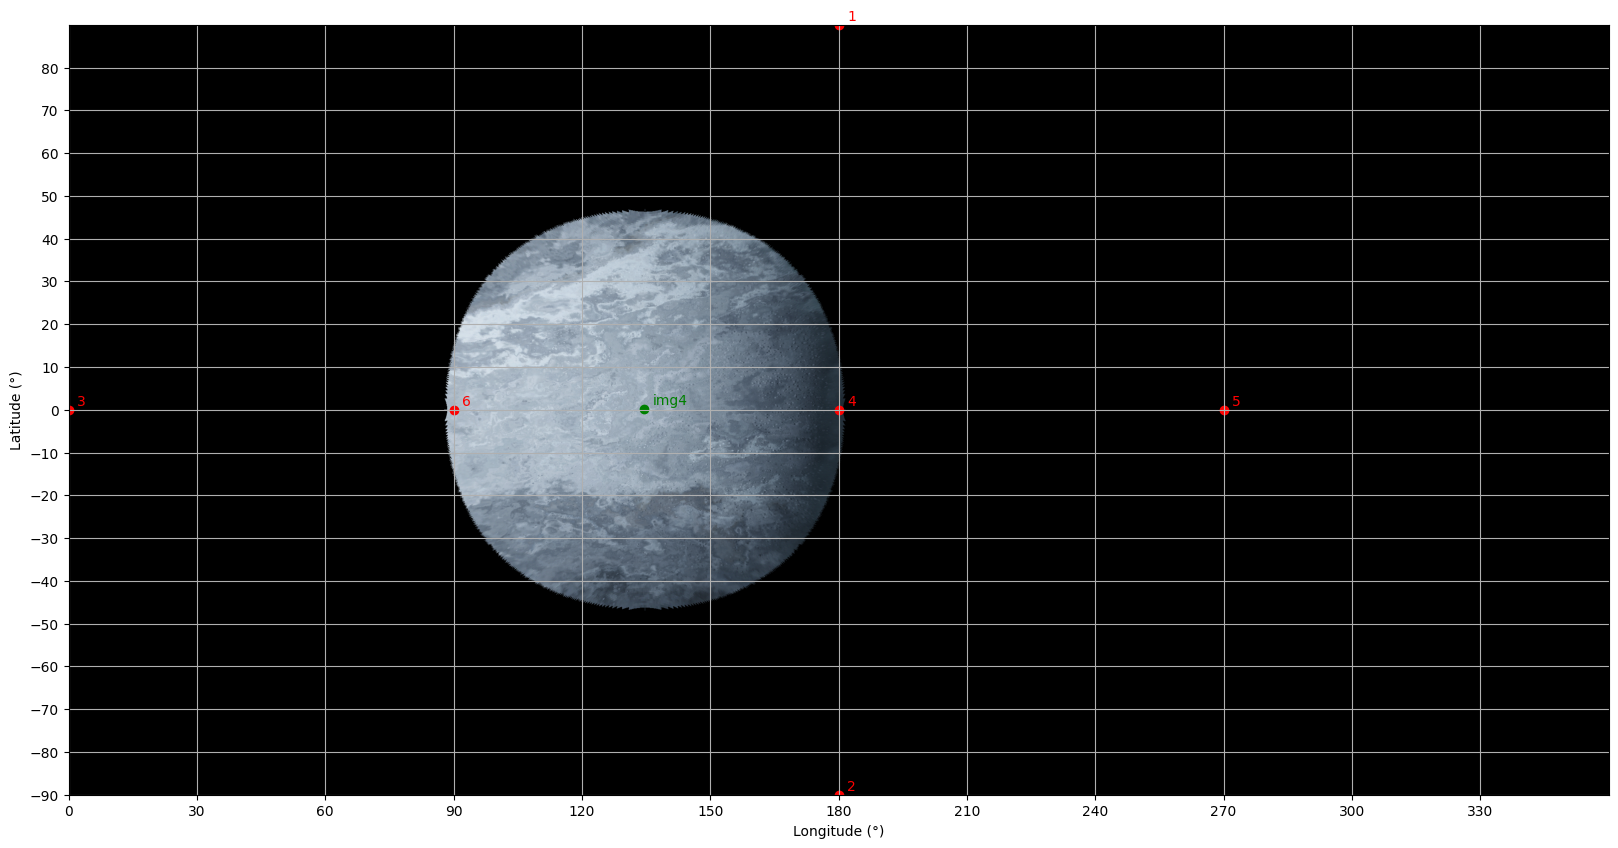

In [18]:
drawMapGrid(testMap3, [cam4longla], ["img4"])

In [19]:
combineMap2 = np.copy(combineMap)

for v in range(OUTPUT_IMG_SIZE[1]):
    for u in range(OUTPUT_IMG_SIZE[0]):
        if (combineMap2[v,u] != [0, 0, 0]).all() and (testMap3[v,u] != [0, 0, 0]).all():
            combineMap2[v,u] = (combineMap2[v,u] + testMap3[v,u]) / 2
        else:
            combineMap2[v,u] = (combineMap2[v,u] + testMap3[v,u])

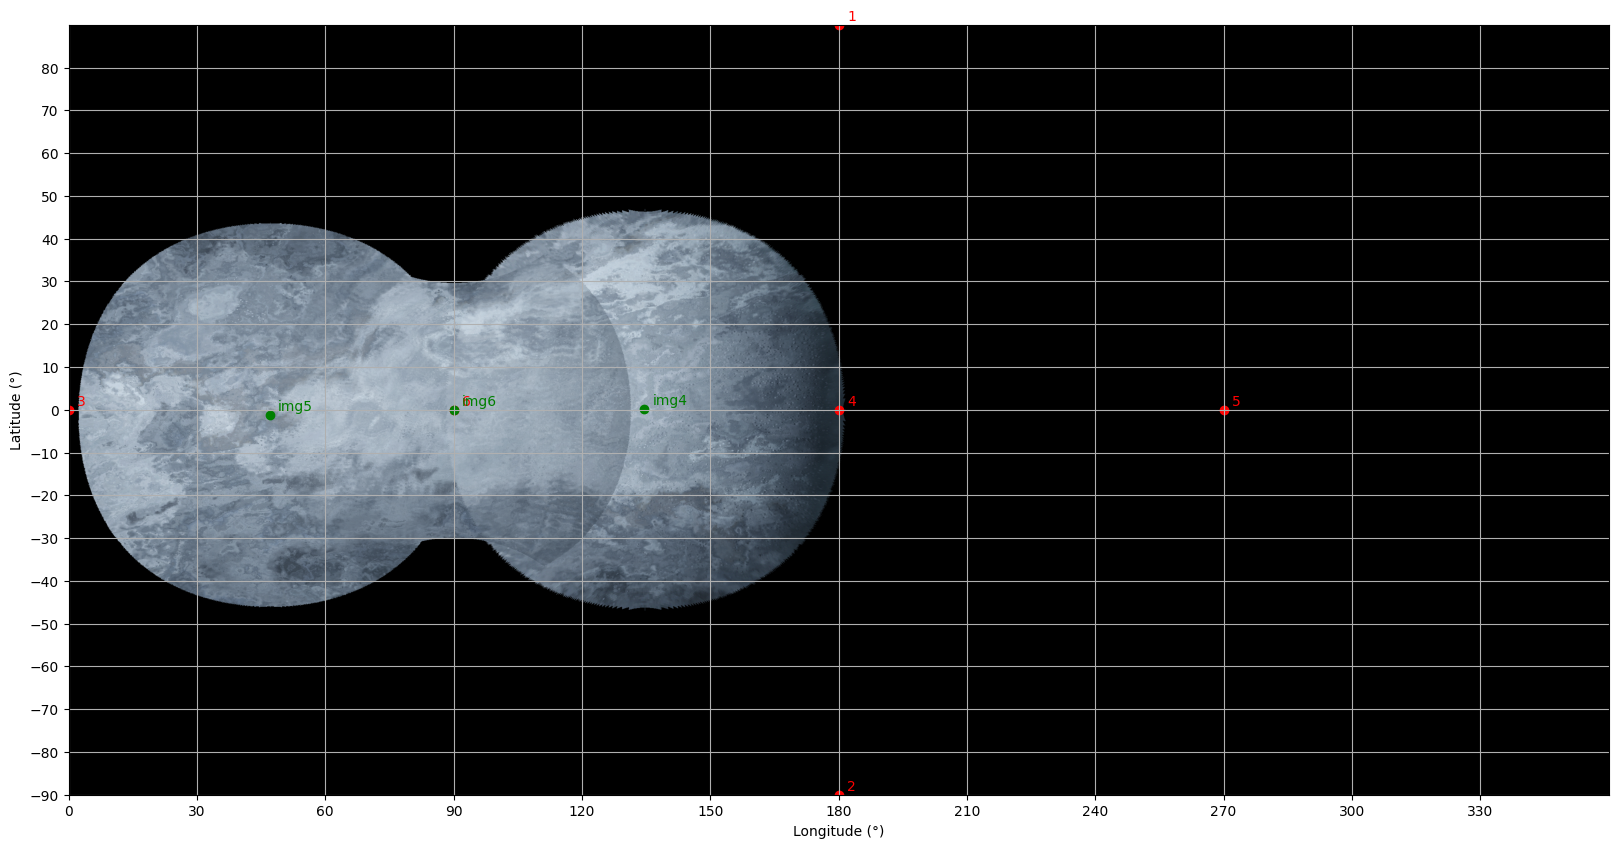

In [20]:
drawMapGrid(combineMap2, [cam5longla, cam6longla, cam4longla], ["img5", "img6", "img4"])

# Two-View Stereo
Synthesize img5 and img6 using correspondence points to calibrate. The correspondence points are labeled manually.

In [21]:
PATH_PAIRS = "./pairs/"

In [83]:
f = open(PATH_PAIRS + "5_6" + ".json")
pairs_5_6 = json.load(f)

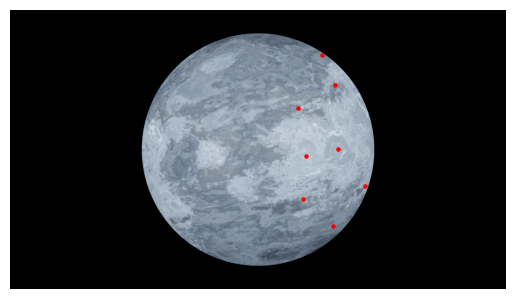

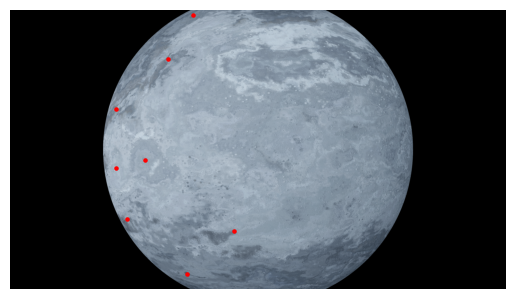

In [84]:
pt_5 = np.array(pairs_5_6["pt_5"])
pt_6 = np.array(pairs_5_6["pt_6"])
ld.showImgWithPts(img5, pt_5)
ld.showImgWithPts(img6, pt_6)

## Compute Fundamental Matrix

In [85]:
def compute_T(pts):
    c = np.mean(pts, axis=0)
    d = np.sqrt(2) / np.mean(np.linalg.norm(pts - c, axis=1))
    T = np.array([[d, 0, -d * c[0]],
                  [0, d, -d * c[1]],
                  [0, 0, 1]])
    return T

def normalize_pts(pts, T):
    num = pts.shape[0]
    return (T @ np.hstack((pts, np.ones((num, 1)))).T).T[:, :2]

In [86]:
# Compute the fundamental matrix F using homogeneous linear least-squares
def compute_F(pts1, pts2, useHarltley = False):
    """
    Params:
    -------
    pts1: np.array
            array of size (N, 2). N points of coordinates (x, y) in view 1.
    pts2: np.array
            array of size (N, 2). N points of coordinates (x, y) in view 2.

    Returns:
    --------
    F: np.array
            array of size (3, 3). Fundamental matrix.
    """
    if useHarltley:
        num = pts1.shape[0]
        T1 = compute_T(pts1)
        pts1_normalized = normalize_pts(pts1, T1)
        T2 = compute_T(pts2)
        pts2_normalized = normalize_pts(pts2, T2)

        A = np.hstack((pts1_normalized, np.ones((num, 1))))
        B = np.hstack((pts2_normalized, np.ones((num, 1))))
        A_mtx = np.hstack((A[:, 0:1] * B, A[:, 1:2] * B, B))

        # Compute SVD of A
        _, _, V = np.linalg.svd(A_mtx)
        F_tilde = V[-1].reshape(3, 3)

        U, S, Vt = np.linalg.svd(F_tilde)
        F_bar = U @ np.diag([S[0], S[1], 0]) @ Vt

        F = T1.T @ F_bar @ T2
    else:
        num = pts1.shape[0]

        A = []

        for i in range(num):
            x_i,  y_i  = pts1[i]
            xp_i, yp_i = pts2[i]
            A.append([x_i * xp_i, x_i * yp_i, x_i, y_i * xp_i, y_i * yp_i, y_i, xp_i, yp_i, 1])
            
        A = np.array(A)

        # Compute SVD of A
        U, S, Vh = np.linalg.svd(A)

        # Solve for F
        F = Vh[-1].reshape(3, 3)
        F = F / np.linalg.norm(F)
    return F

## Draw Epipolar Lines

In [87]:
def draw_epipolar_lines(img, pts1, pts2, F):
    """
    Params:
    -------
    pts1: np.array
        array of size (N, 2). N points of coordinates (x, y) in view 1.
    pts2: np.array
        array of size (N, 2). N points of coordinates (x, y) in view 2.
    F: np.array
        array of size (3, 3). fundamental matrix.

    Returns:
    --------
    lines: list
        list of tuples. Each tuple contains the coordinates of the two extremal points of the epipolar segment drawn.
    """
    lines = []

    plt.figure()
    plt.imshow(img)
    plt.axis('off')  # Turn off axis
    for i in range(len(pts1)):
        plt.scatter(pts2[i,0], pts2[i,1], s=10)
        
    # fix the xlim and ylim
    xlim = plt.xlim()
    ylim = plt.ylim()
    plt.xlim(xlim)
    plt.ylim(ylim)
    
    h, w, _ = img.shape
        
    for i in range(len(pts1)):
        # Get homogeneous coordinates
        pt1_homo = np.hstack((pts1[i], 1))
        pt2_homo = np.hstack((pts2[i], 1))
        # pt1.T @ F @ pt2 = 0
        # F.T @ pt1 = l2
        #   F @ pt2 = l1
        epipolarLine1inView2 = F.T @ pt1_homo
        
        epiPtLeft = [0, -epipolarLine1inView2[2] / epipolarLine1inView2[1]]
        epiPtRight = [w, (-epipolarLine1inView2[2] - epipolarLine1inView2[0] * w) / epipolarLine1inView2[1]]
        
        lines.append((epiPtLeft, epiPtRight))
        
        plt.plot([epiPtLeft[0], epiPtRight[0]], [epiPtLeft[1], epiPtRight[1]], alpha=0.5)
        
    return lines

In [88]:
F56 = compute_F(pt_5, pt_6)
print(F56)

[[ 1.56444034e-07  3.03427123e-07 -3.87068887e-04]
 [ 4.93302262e-08  4.14701940e-08  4.48495268e-04]
 [-5.39842523e-04 -1.16671908e-03  9.99998998e-01]]


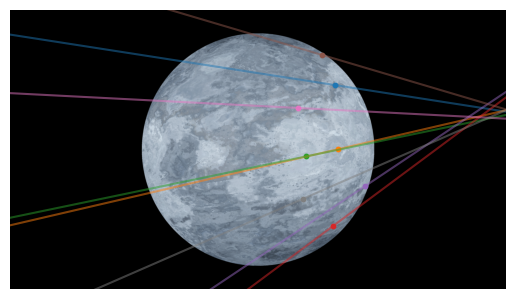

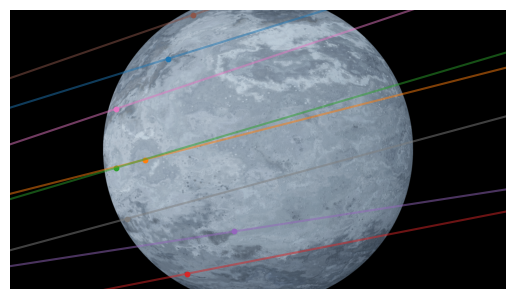

In [89]:
l = draw_epipolar_lines(img5, pt_6, pt_5, F56.T)
l = draw_epipolar_lines(img6, pt_5, pt_6, F56)

The result is unsatisfied. Try using CV library.

## Using CV's Algorithm to get Fundamental Matrix

[[-1.27071347e-08  3.99275435e-07 -4.52788169e-04]
 [ 1.94558422e-07 -5.00397266e-08  8.32787336e-04]
 [-1.57367429e-04 -1.62308341e-03  1.00000000e+00]]


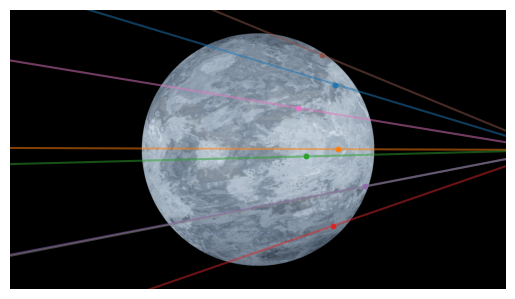

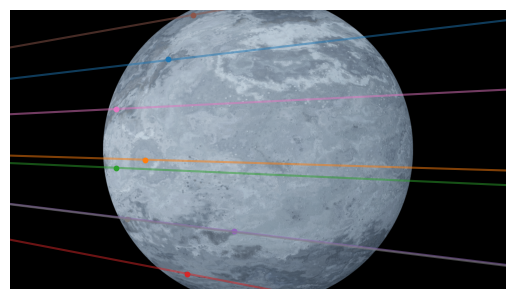

In [93]:
F65cv, mask = cv.findFundamentalMat(pt_5, pt_6, cv.FM_LMEDS)
F56cv = F65cv.T
print(F56cv)

l = draw_epipolar_lines(img5, pt_6, pt_5, F56cv.T)
l = draw_epipolar_lines(img6, pt_5, pt_6, F56cv)

# ~~Multi Image Projection~~
Using method "Structure from motion".

https://en.wikipedia.org/wiki/Structure_from_motion

Possible application for reference: https://www.capturingreality.com/realitycapture-13